Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Best RMSE: 2576.0625766451567


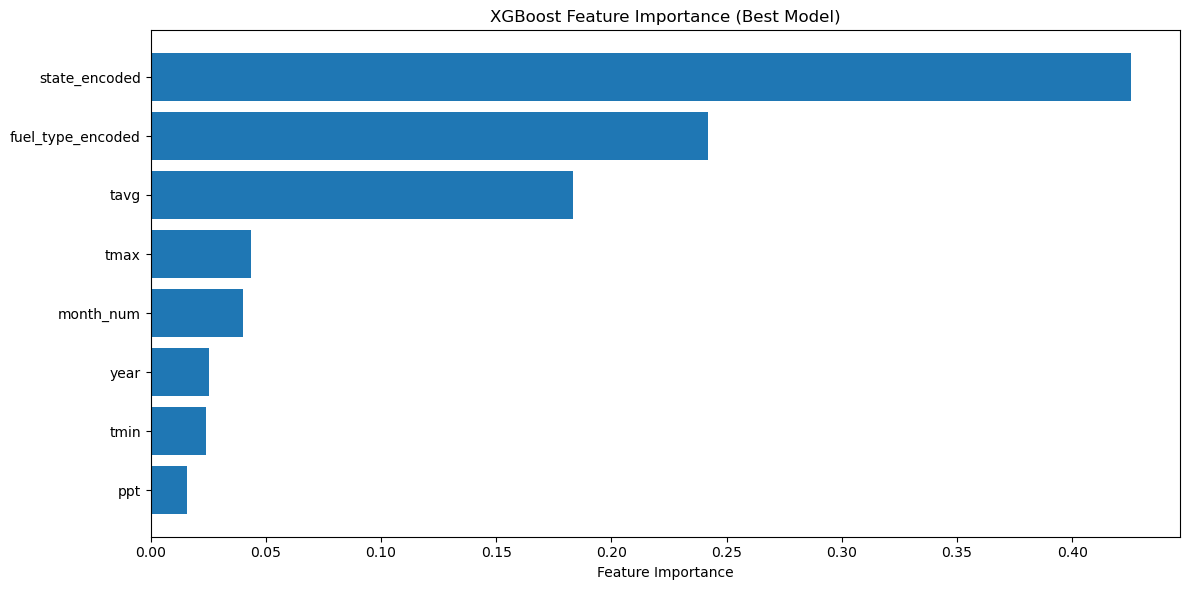

Predicted energy consumption for natural gas in Michigan: 38220.1953125


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Load the data
df = pd.read_csv('Resources/energy_weather_data.csv')

# 2. Prepare the features and target
# Convert month names to numeric
df['month_num'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%B').dt.month

# Encode 'fuel_type' and 'state' as categorical variables
le_fuel = LabelEncoder()
le_state = LabelEncoder()
df['fuel_type_encoded'] = le_fuel.fit_transform(df['fuel_type'])
df['state_encoded'] = le_state.fit_transform(df['state'])

# Select features (including fuel_type and state)
features = df[['year', 'month_num', 'tmin', 'tmax', 'tavg', 'ppt', 'fuel_type_encoded', 'state_encoded']]
target = df['energy_consumption']

# 3. Use TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=20) # 20 splits seems to be the optimal number for this dataset

# 4. Create the XGBoost model and define parameter space for tuning
model = XGBRegressor(random_state=42)

param_space = {
    'n_estimators': [100, 500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 5. Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_space,
    n_iter=100,  # Number of parameter settings sampled
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=2
)

# 6. Fit the random search to the data
random_search.fit(features, target)

# 7. Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

# 8. Use the best model for predictions
best_model = random_search.best_estimator_

# 9. Feature importance (using the best model)
feature_importance = best_model.feature_importances_
feature_names = features.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance (Best Model)')
plt.tight_layout()
plt.show()

# 10. Example prediction (using the best model)
fuel_type = 'natural gas'
state = 'Michigan'

example_data = pd.DataFrame({
    'year': [2024],
    'month_num': [12],
    'tmin': [-1.472],
    'tmax': [4.816],
    'tavg': [1.672],
    'ppt': [49.936],
    'fuel_type_encoded': [le_fuel.transform([fuel_type])[0]],
    'state_encoded': [le_state.transform([state])[0]]
})

prediction = best_model.predict(example_data)
print(f"Predicted energy consumption for {fuel_type} in {state}: {prediction[0]}")

C:\Users\Owner\AppData\Local\Temp\ipykernel_14236\1842589943.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')
C:\Users\Owner\AppData\Local\Temp\ipykernel_14236\1842589943.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  historical_dates = pd.to_datetime(historical_data['year'].astype(str) + '-' + historical_data['month'].astype(str))


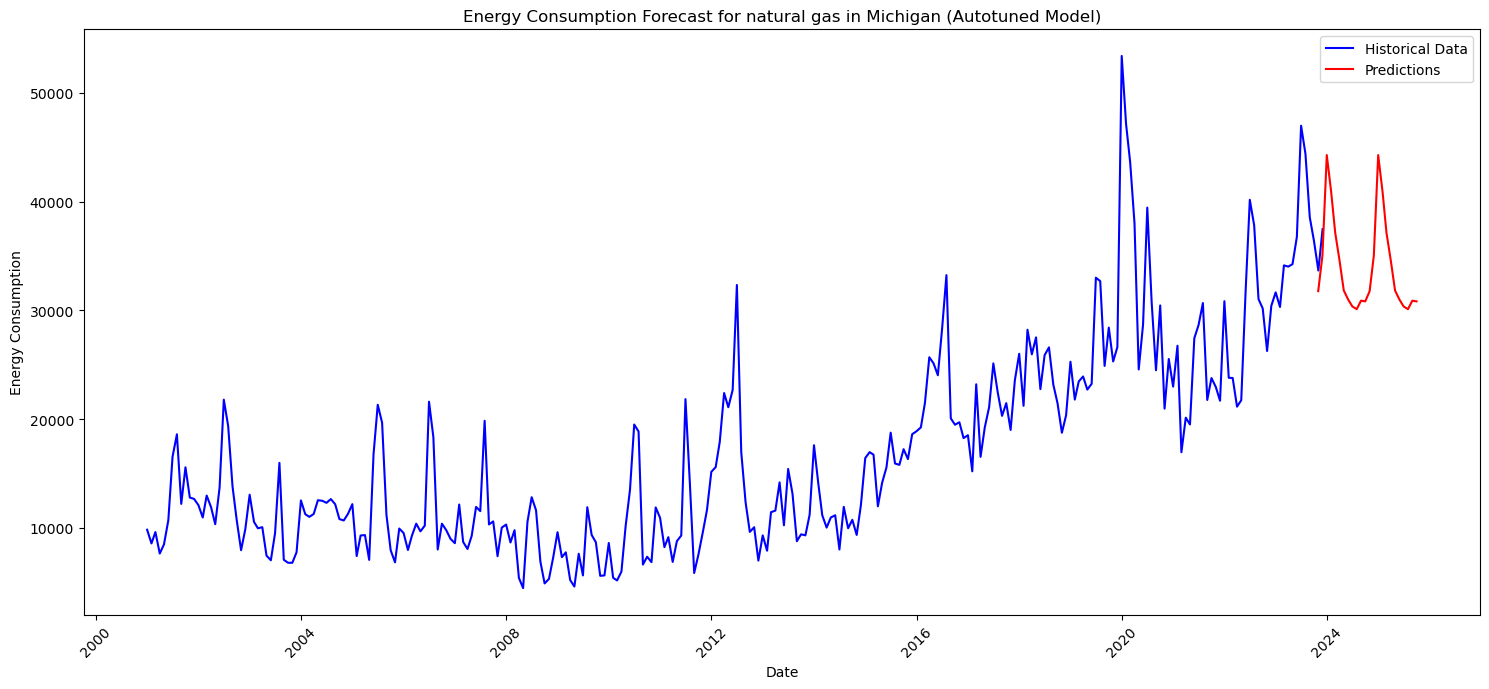

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Generate future dates
last_date = pd.to_datetime(f"{df['year'].max()}-{df['month'].max()}")
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')

# 2. Create a DataFrame for future predictions
future_df = pd.DataFrame({
    'year': future_dates.year,
    'month_num': future_dates.month,
    'tmin': df['tmin'].mean(),
    'tmax': df['tmax'].mean(),
    'tavg': df['tavg'].mean(),
    'ppt': df['ppt'].mean(),
    'fuel_type_encoded': le_fuel.transform([fuel_type] * len(future_dates)),
    'state_encoded': le_state.transform([state] * len(future_dates))
})

# 3. Make predictions using the best model
future_predictions = best_model.predict(future_df)

# 4. Prepare historical data for the specified fuel type and state
historical_data = df[(df['state'] == state) & (df['fuel_type'] == fuel_type)]
historical_dates = pd.to_datetime(historical_data['year'].astype(str) + '-' + historical_data['month'].astype(str))

# 5. Create the plot
plt.figure(figsize=(15, 7))
plt.plot(historical_dates, historical_data['energy_consumption'], label='Historical Data', color='blue')
plt.plot(future_dates, future_predictions, label='Predictions', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title(f'Energy Consumption Forecast for {fuel_type} in {state} (Autotuned Model)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
# Generate predictions
y_pred = best_model.predict(features)

# Calculate R2 score
r2 = best_model.score(features, target)

# Calculate MAE
mae = np.mean(np.abs(target - y_pred))

# Calculate MSE
mse = mean_squared_error(target, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(target, y_pred))

# Calculate accuracy percentage
accuracy_percentage = 100 - (rmse / np.mean(target) * 100)
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Percentage Accuracy: {accuracy_percentage:.2f}%")

R2 Score: 1.00
Mean Absolute Error: 470.56
Mean Squared Error: 742066.81
Root Mean Squared Error: 861.43
Percentage Accuracy: 81.18%


Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Best RMSE: 2576.0625766451567


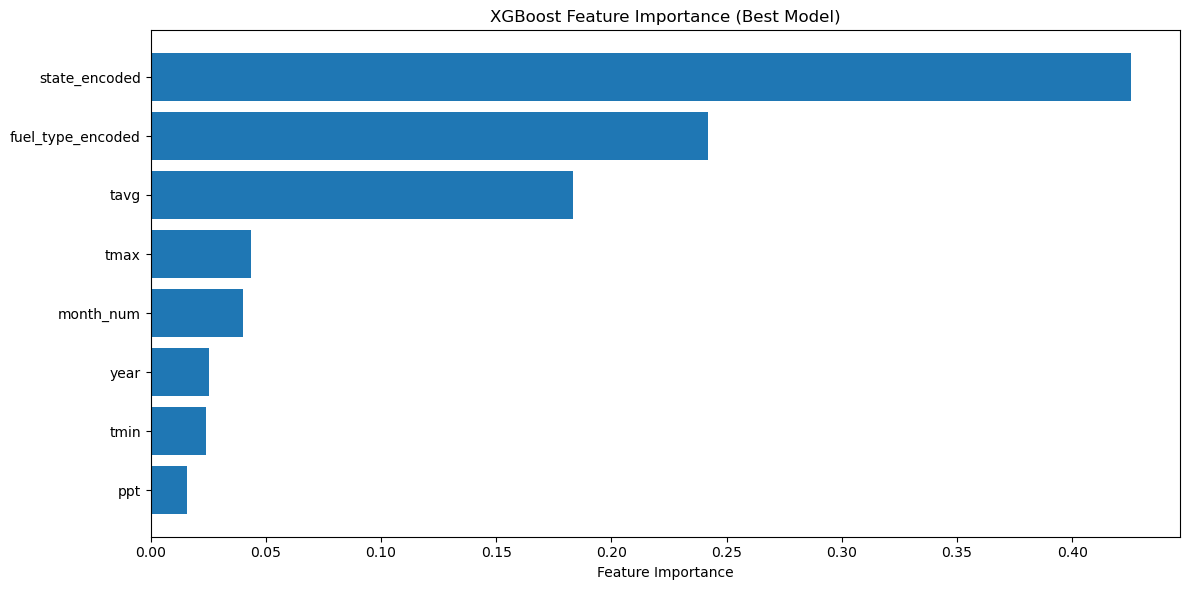

Predicted energy consumption for coal in Alabama: 803.93603515625


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Load the data
df = pd.read_csv('Resources/energy_weather_data.csv')

# 2. Prepare the features and target
# Convert month names to numeric
df['month_num'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%B').dt.month

# Encode 'fuel_type' and 'state' as categorical variables
le_fuel = LabelEncoder()
le_state = LabelEncoder()
df['fuel_type_encoded'] = le_fuel.fit_transform(df['fuel_type'])
df['state_encoded'] = le_state.fit_transform(df['state'])

# Select features (including fuel_type and state)
features = df[['year', 'month_num', 'tmin', 'tmax', 'tavg', 'ppt', 'fuel_type_encoded', 'state_encoded']]
target = df['energy_consumption']

# 3. Use TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=20) # 20 splits seems to be the optimal number for this dataset

# 4. Create the XGBoost model and define parameter space for tuning
model = XGBRegressor(random_state=42)

param_space = {
    'n_estimators': [100, 500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 5. Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_space,
    n_iter=100,  # Number of parameter settings sampled
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=2
)

# 6. Fit the random search to the data
random_search.fit(features, target)

# 7. Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

# 8. Use the best model for predictions
best_model = random_search.best_estimator_

# 9. Feature importance (using the best model)
feature_importance = best_model.feature_importances_
feature_names = features.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance (Best Model)')
plt.tight_layout()
plt.show()

# 10. Example prediction (using the best model)
fuel_type = 'coal'
state = 'Alabama'

example_data = pd.DataFrame({
    'year': [2025],
    'month_num': [12],
    'tmin': [2.652],
    'tmax': [15.471],
    'tavg': [9.062],
    'ppt': [94.212],
    'fuel_type_encoded': [le_fuel.transform([fuel_type])[0]],
    'state_encoded': [le_state.transform([state])[0]]
})

prediction = best_model.predict(example_data)
print(f"Predicted energy consumption for {fuel_type} in {state}: {prediction[0]}")

C:\Users\Owner\AppData\Local\Temp\ipykernel_14236\1842589943.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')
C:\Users\Owner\AppData\Local\Temp\ipykernel_14236\1842589943.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  historical_dates = pd.to_datetime(historical_data['year'].astype(str) + '-' + historical_data['month'].astype(str))


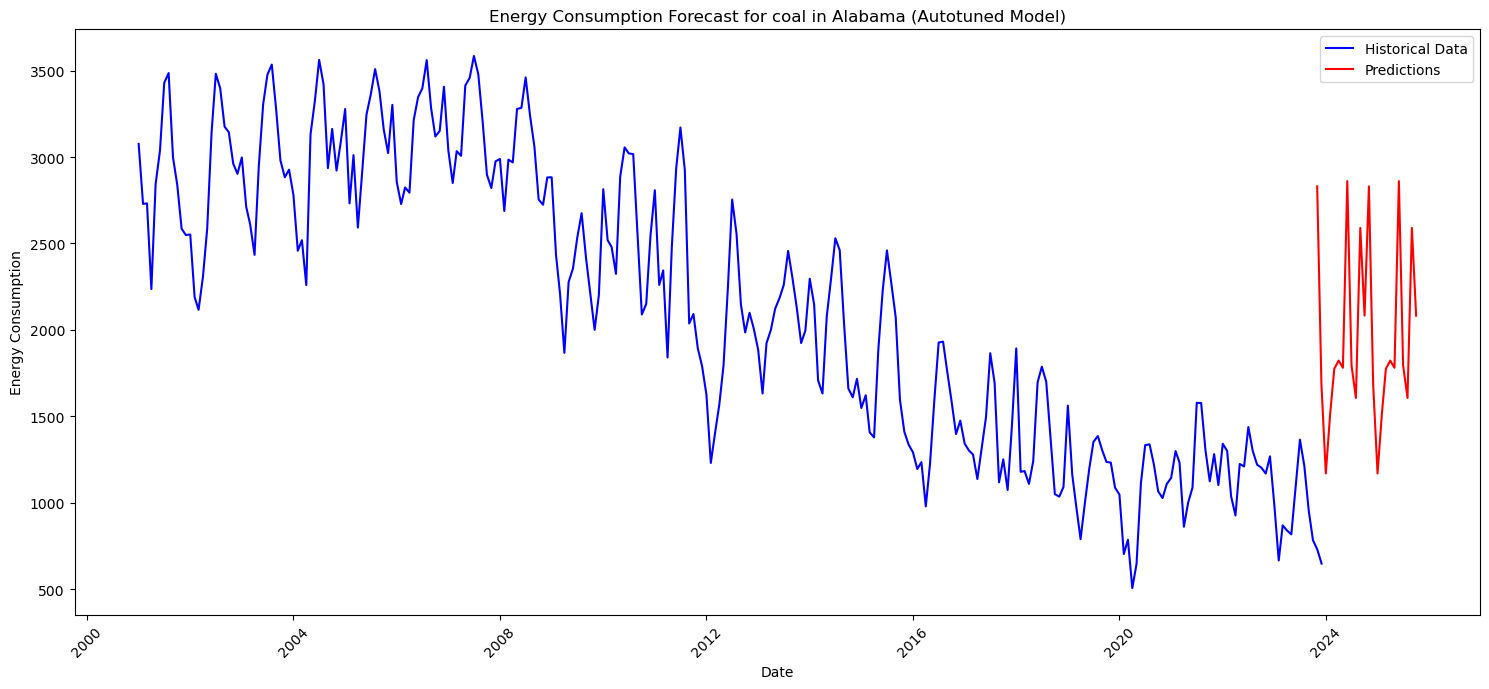

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Generate future dates
last_date = pd.to_datetime(f"{df['year'].max()}-{df['month'].max()}")
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')

# 2. Create a DataFrame for future predictions
future_df = pd.DataFrame({
    'year': future_dates.year,
    'month_num': future_dates.month,
    'tmin': df['tmin'].mean(),
    'tmax': df['tmax'].mean(),
    'tavg': df['tavg'].mean(),
    'ppt': df['ppt'].mean(),
    'fuel_type_encoded': le_fuel.transform([fuel_type] * len(future_dates)),
    'state_encoded': le_state.transform([state] * len(future_dates))
})

# 3. Make predictions using the best model
future_predictions = best_model.predict(future_df)

# 4. Prepare historical data for the specified fuel type and state
historical_data = df[(df['state'] == state) & (df['fuel_type'] == fuel_type)]
historical_dates = pd.to_datetime(historical_data['year'].astype(str) + '-' + historical_data['month'].astype(str))

# 5. Create the plot
plt.figure(figsize=(15, 7))
plt.plot(historical_dates, historical_data['energy_consumption'], label='Historical Data', color='blue')
plt.plot(future_dates, future_predictions, label='Predictions', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title(f'Energy Consumption Forecast for {fuel_type} in {state} (Autotuned Model)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# Generate predictions
y_pred = best_model.predict(features)

# Calculate R2 score
r2 = best_model.score(features, target)

# Calculate MAE
mae = np.mean(np.abs(target - y_pred))

# Calculate MSE
mse = mean_squared_error(target, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(target, y_pred))

# Calculate accuracy percentage
accuracy_percentage = 100 - (rmse / np.mean(target) * 100)
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Percentage Accuracy: {accuracy_percentage:.2f}%")

R2 Score: 1.00
Mean Absolute Error: 470.56
Mean Squared Error: 742066.81
Root Mean Squared Error: 861.43
Percentage Accuracy: 81.18%


Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
Best RMSE: 2576.0625766451567


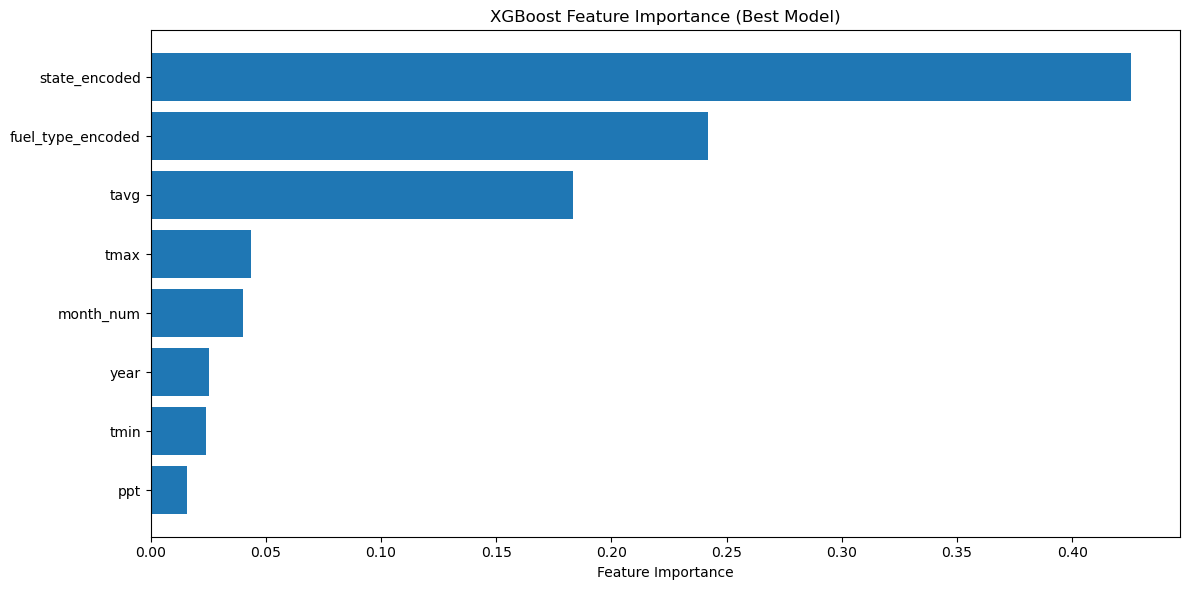

Predicted energy consumption for coal in Texas: 2870.635009765625


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 1. Load the data
df = pd.read_csv('Resources/energy_weather_data.csv')

# 2. Prepare the features and target
# Convert month names to numeric
df['month_num'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%B').dt.month

# Encode 'fuel_type' and 'state' as categorical variables
le_fuel = LabelEncoder()
le_state = LabelEncoder()
df['fuel_type_encoded'] = le_fuel.fit_transform(df['fuel_type'])
df['state_encoded'] = le_state.fit_transform(df['state'])

# Select features (including fuel_type and state)
features = df[['year', 'month_num', 'tmin', 'tmax', 'tavg', 'ppt', 'fuel_type_encoded', 'state_encoded']]
target = df['energy_consumption']

# 3. Use TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=20) # 20 splits seems to be the optimal number for this dataset

# 4. Create the XGBoost model and define parameter space for tuning
model = XGBRegressor(random_state=42)

param_space = {
    'n_estimators': [100, 500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 5. Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_space,
    n_iter=100,  # Number of parameter settings sampled
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=2
)

# 6. Fit the random search to the data
random_search.fit(features, target)

# 7. Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

# 8. Use the best model for predictions
best_model = random_search.best_estimator_

# 9. Feature importance (using the best model)
feature_importance = best_model.feature_importances_
feature_names = features.columns
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_xlabel('Feature Importance')
ax.set_title('XGBoost Feature Importance (Best Model)')
plt.tight_layout()
plt.show()

# 10. Example prediction (using the best model)
fuel_type = 'coal'
state = 'Texas'

example_data = pd.DataFrame({
    'year': [2024],
    'month_num': [12],
    'tmin': [3.646],
    'tmax': [17.749],
    'tavg': [10.697],
    'ppt': [48.275],
    'fuel_type_encoded': [le_fuel.transform([fuel_type])[0]],
    'state_encoded': [le_state.transform([state])[0]]
})

prediction = best_model.predict(example_data)
print(f"Predicted energy consumption for {fuel_type} in {state}: {prediction[0]}")

C:\Users\Owner\AppData\Local\Temp\ipykernel_14236\1842589943.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')
C:\Users\Owner\AppData\Local\Temp\ipykernel_14236\1842589943.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  historical_dates = pd.to_datetime(historical_data['year'].astype(str) + '-' + historical_data['month'].astype(str))


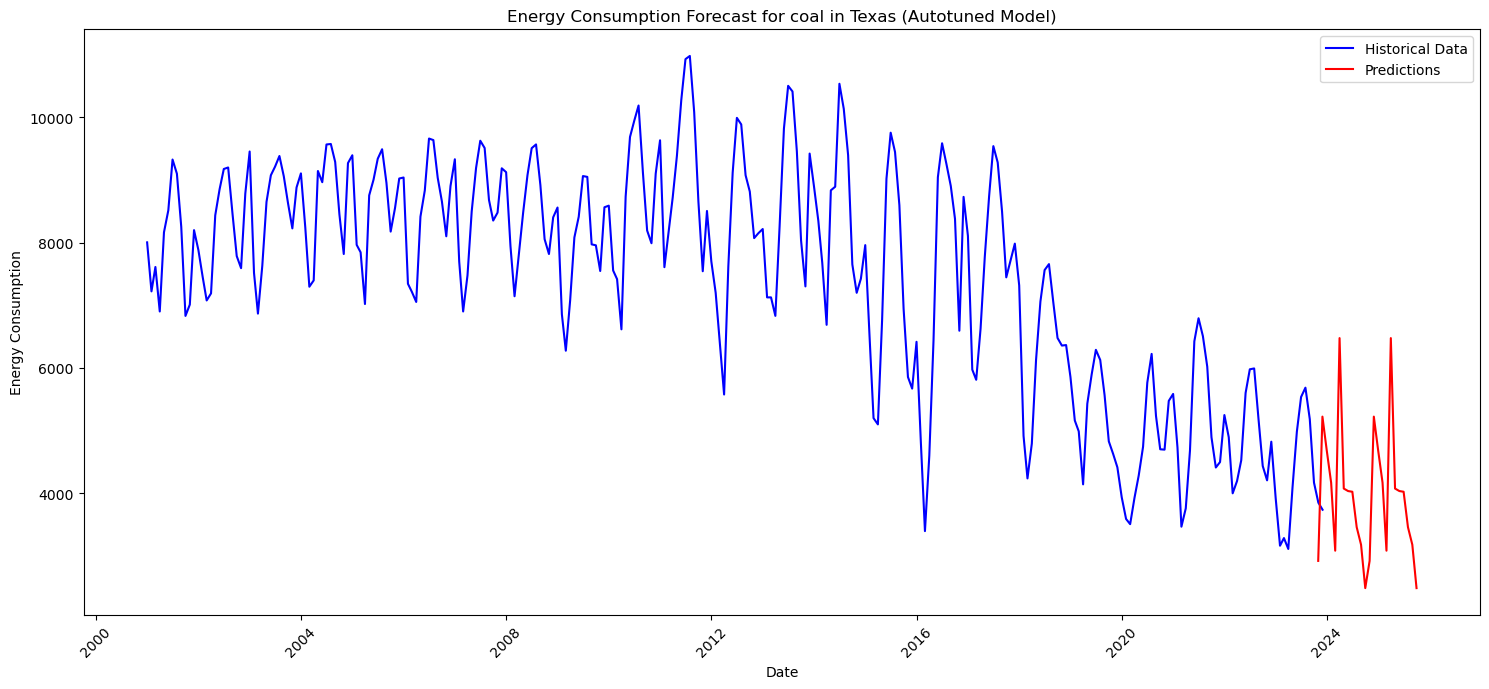

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Generate future dates
last_date = pd.to_datetime(f"{df['year'].max()}-{df['month'].max()}")
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='M')

# 2. Create a DataFrame for future predictions
future_df = pd.DataFrame({
    'year': future_dates.year,
    'month_num': future_dates.month,
    'tmin': df['tmin'].mean(),
    'tmax': df['tmax'].mean(),
    'tavg': df['tavg'].mean(),
    'ppt': df['ppt'].mean(),
    'fuel_type_encoded': le_fuel.transform([fuel_type] * len(future_dates)),
    'state_encoded': le_state.transform([state] * len(future_dates))
})

# 3. Make predictions using the best model
future_predictions = best_model.predict(future_df)

# 4. Prepare historical data for the specified fuel type and state
historical_data = df[(df['state'] == state) & (df['fuel_type'] == fuel_type)]
historical_dates = pd.to_datetime(historical_data['year'].astype(str) + '-' + historical_data['month'].astype(str))

# 5. Create the plot
plt.figure(figsize=(15, 7))
plt.plot(historical_dates, historical_data['energy_consumption'], label='Historical Data', color='blue')
plt.plot(future_dates, future_predictions, label='Predictions', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title(f'Energy Consumption Forecast for {fuel_type} in {state} (Autotuned Model)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
# Generate predictions
y_pred = best_model.predict(features)

# Calculate R2 score
r2 = best_model.score(features, target)

# Calculate MAE
mae = np.mean(np.abs(target - y_pred))

# Calculate MSE
mse = mean_squared_error(target, y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(target, y_pred))

# Calculate accuracy percentage
accuracy_percentage = 100 - (rmse / np.mean(target) * 100)
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Percentage Accuracy: {accuracy_percentage:.2f}%")

R2 Score: 1.00
Mean Absolute Error: 470.56
Mean Squared Error: 742066.81
Root Mean Squared Error: 861.43
Percentage Accuracy: 81.18%
